# P8_1D

Este notebook te mostrará como utilizar los procesos Gausianos para resolver un problema de regresión de 1D. 

Esta parte es adaptada de una práctica hecha por *Ruben Martínez-Cantín* (basada en "*GPSS labs*")

## Nombre:

## NIP:

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    ExpSineSquared,
    RationalQuadratic,
    WhiteKernel,
)

%matplotlib inline

## Load 1D dataset with weight measurements

We will use the 
[weight dataset](https://drive.google.com/file/d/1YYyQG-xuS1OV5Ww1ytZLzhe3YdvE_NKG/view?usp=sharing) 
from [Philipp Hennig](https://uni-tuebingen.de/en/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/personen/philipp-hennig/)

You can find it in the material provided for the lab.

Tamaño de X: (842, 1)
Tamaño de y: (842, 1)


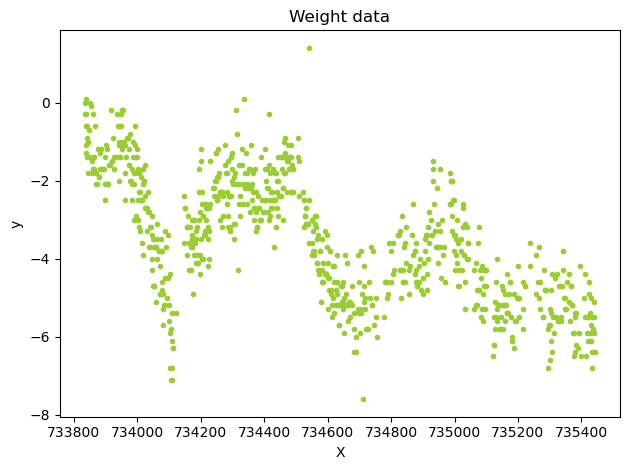

In [2]:
# Load the weight dataset
data = scipy.io.loadmat("weightdata_clean.mat")
X, y = data["dat"][:, 0:1], data["dat"][:, 1:]

# set the step to subsample the dataset
subsample = 1
X = X[::subsample]
y = y[::subsample]

# Make sure the data is there
print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de y: {y.shape}")

# Plot the data
fig, ax = plt.subplots()
ax.scatter(X, y, color="yellowgreen", marker=".")
ax.set(xlabel="X", ylabel="y", title="Weight data")
fig.tight_layout()

In [3]:
def plot_gp2(X, m, std_pred, training_points=None):
    """Plotting utility to plot a GP fit with 95% confidence interval"""
    fig, ax = plt.subplots()
    ax.plot(X, m, label="Mean prediction")
    ax.fill_between(
        X.ravel(),
        m - 1.96 * std_pred,
        m + 1.96 * std_pred,
        alpha=0.5,
        label=r"95% confidence interval",
    )

    if training_points is not None:
        X_, Y_ = training_points
        ax.plot(X_, Y_, "kx", mew=2)
        ax.legend(labels=["GP fit", "sample points"])

    ax.set(xlabel="$x$", ylabel="$f(x)$", title="Gaussian process regression")
    ax.legend()
    fig.tight_layout()

# Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using the available 
[kernels](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process.kernels).

The most commonly used kernel in machine learning is the Gaussian-form radial basis function <br> 
(RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential <br> 
kernel &ndash;all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:
$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In `scikit-learn`, the RBF kernel does not have an explicit $\sigma^2$ hyperparameter (although <br>
we can multiply the kernel by a constant to achieve the same effect). The lengthscale $\mathscr{l}$ is the <br> 
`length_scale` parameter. Exemplar kernel that we will use for now:

In [4]:
# Define a kernel
sigma = 1.24**2
kernel = sigma * RBF(length_scale=10.6)
# You can print it
print(kernel)

1.24**2 * RBF(length_scale=10.6)


## Gaussian Process Regression
In future exercises, we are going to implement our own Gaussian process. For the time being we <br> 
can do Gaussian process regression using `GaussianProcessRegressor`, by creating a GP <br>
 regression model with sample points $(\mathbf{X}, \mathbf{y})$ and the Gaussian RBF kernel:

kernel: 1.24**2 * RBF(length_scale=10.6)
Log-marginal-likelihood: -4452.472


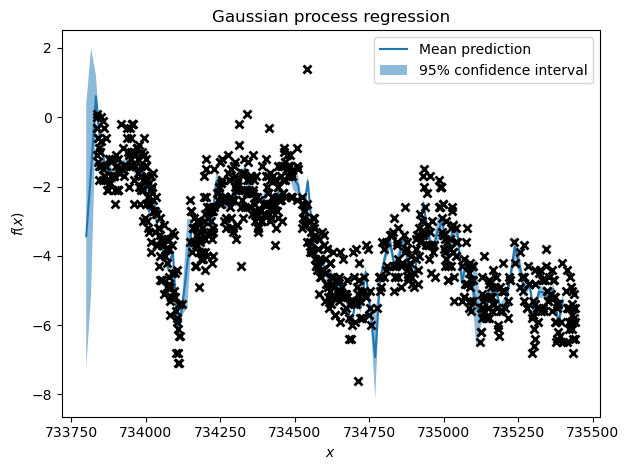

In [5]:
# no hyperparameter optimization (specified with optimizer=None):
gpr = GaussianProcessRegressor(
    kernel=kernel, normalize_y=True, alpha=0.1**2, optimizer=None
)
gpr.fit(X, y)
# ensure the kernel does not change
print(f"kernel: {gpr.kernel_}")
print(f"Log-marginal-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}")

# New test points to sample function from
Xnew = np.linspace(733800, 735400, 100)[:, None]
mean_prediction, std_prediction = gpr.predict(Xnew, return_std=True)  # type: ignore

# Plot the GP fit mean and covariance
plot_gp2(Xnew, mean_prediction, std_prediction, training_points=(X, y))

## Hyperparameter learning

Instead of selecting the hyperparameters by hand, we can learn them from the data. <br>
By default, GPy uses the log-likelihood of the evidence to estimate the optimal parameters.
$$
\theta^* = \arg\max_\theta \log p(\mathbf{y}|\mathbf{X})
$$

<!-- In practice, the optimization algorithm used is for minimization. Thus, we minimize the negative <br>  
log-likelihood, which should give the same result.

$$
\theta^* = \arg\min_\theta - \log p(\mathbf{y}|\mathbf{X})
$$

You can see how the "Objective" (negative log-likelihood) value decreases compared to the hand selected parameters.
-->

You can see how the likelihood value increases compared to the hand selected parameters:

kernel: 0.912**2 * RBF(length_scale=1.13)
Log-marginal-likelihood: -928.909


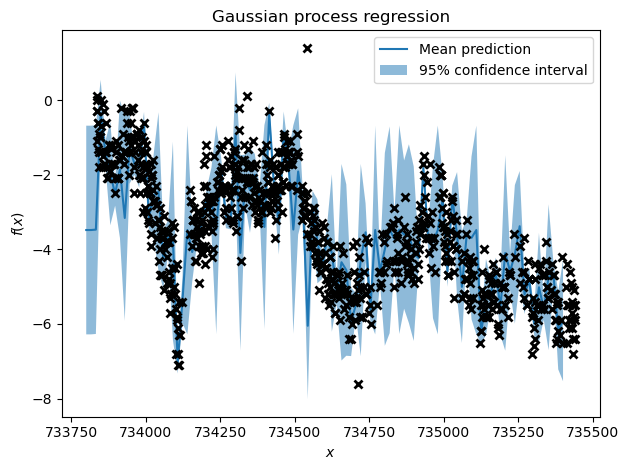

In [6]:
# This time we optimize the hyperparameters
gpr = GaussianProcessRegressor(
    kernel=kernel, normalize_y=True, alpha=0.1**2, n_restarts_optimizer=10
)
gpr.fit(X, y)
# optimized kernel
print(f"kernel: {gpr.kernel_}")
print(f"Log-marginal-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}")

mean_prediction, std_prediction = gpr.predict(Xnew, return_std=True)  # type: ignore

# Plot the GP fit mean and covariance
plot_gp2(Xnew, mean_prediction, std_prediction, training_points=(X, y))

# Observation noise

Add a noise kernel to model observation noise

3**2 * RBF(length_scale=26) + WhiteKernel(noise_level=0.436)
0.795**2 * RBF(length_scale=26.2) + WhiteKernel(noise_level=0.157)


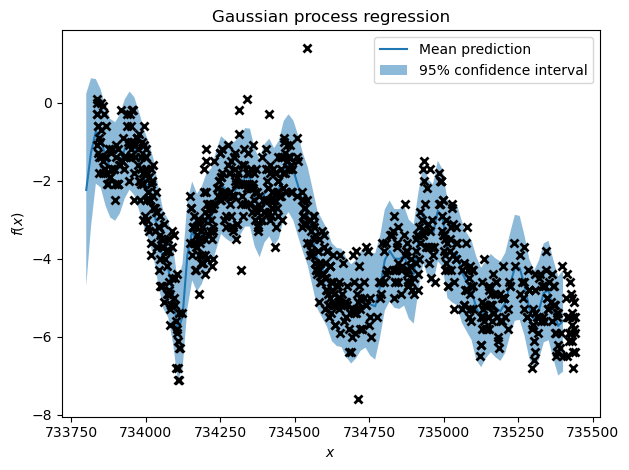

In [8]:
# custom kernel
cte1 = ConstantKernel(9)
noise = WhiteKernel(noise_level=0.66**2, noise_level_bounds=(1e-5, 1e5))
kernel = cte1 * RBF(length_scale=26) + noise
print(kernel)

gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, alpha=0.1**2)
gpr.fit(X, y)
print(gpr.kernel_)
mean_prediction, std_prediction = gpr.predict(Xnew, return_std=True)  # type: ignore

# Plot the GP fit mean and covariance
plot_gp2(Xnew, mean_prediction, std_prediction, training_points=(X, y))

# Tareas

El objetivo de esta parte de la práctica es que entiendas el papel de los kernels y de <br> 
los hiperparámetros que los definen. Deberías:

* Haber probado varios kernels (y/o combinaciones de ellos) y haber ajustado los parametros a mano y/o usando la función `fit`. <br> 
¿Qué Kernel te ha dado mejor resultado? ¿Qué métrica has utilizado?

* Haber explorado la optimización. ¿Cambian los resultados si lo ejecutas varias veces? ¿Qué efecto tiene el punto inicial?

* Entender la diferencia entre predicciones con ruido y sin ruido. <br>
¿Que papel juega el ruido? ¿Que valor ha ajustado? ¿Cual es la adecuada para tomar decisiones?

Los métodos Bayesianos son más interesantes cuando hay menos datos. <br> 
Prueba a repetir el proceso con una selección (subsampleada) del dataset. <br>
Puedes utilizar el código que tienes al leer el dataset:
```python
# set the step to subsample the dataset
subsample = 25
X = X[::subsample]
y = y[::subsample]
```
 o simplemente eliminar datos (por trozos, por ejemplo).


*Recuerda*: para justificar tus respuestas, lo mejor es mostrar los datos que soportan tus argumentos <br> 
(los valores de los kernels que has probado manualmente, la regresión resultante, el fit...) <br>
y añade tu justificación de por qué es buena o mala.



